In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.insert(1, '../../')
import velovae as vv
%load_ext autoreload
%autoreload 2

# Section 1: Load Input Data
We demonstrate the full training pipeline using an example dataset from scVelo.

In [2]:
dataset = "Pancreas"
adata = scv.datasets.pancreas()

Set the parent folder names for saving model parameters, data and figures.

In [3]:
model_path = f"checkpoints/{dataset}"
figure_path = f"figures/{dataset}"
data_path = f"data/{dataset}"

<br><br><br><br><br>
# Section 2: Preprocessing
We apply exactly the same preprocessing steps as scVelo.
The "preprocess" function performs the following:
1. Cell and gene filtering based on mRNA counts.<br><br>
2. Select a number of genes. By default, it applies the selection method in scVelo to pick highly variable genes. The user can also choose to pick a balanced set of genes by setting <b>"selection_method"</b> to "balanced", meaning that all cell types have the same number of marker genes. Besides these two options, the user can also input a custom list of genes via the argument <b>"genes_retain"</b>.<br><br>
3. Compute a KNN graph based on PCA and average the count data across k neighbors. Dimension of PCA can be set via the argument <b>"npc"</b>. The user can also set the number of neighbors via <b>"n_neighbors"</b>.<br><br>
4. Optionally performs clustering when <b>"perform_clustering"</b> is set to "True".<br><br>
5. Optionally add informative time prior if <b>"tkey"</b> is set to the key in .obs that contains the capture time (either string or float).<br><br>
5. Optionally computes 2D UMAP embedding when <b>"compute_umap"</b> is set to "True".

In [4]:
n_gene = 2000
vv.preprocess(adata, n_gene)

Filtered out 21061 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
Computing the KNN graph based on X_pca
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Keep raw unspliced/spliced count data.


Pick some genes to plot.

In [5]:
gene_plot = ["Gng12", "Smoc1"]

***
# Section 3: Train a VeloVAE Model
This is the VeloVAE model. In addition to the blocks in the basic model, there is a decoder network producing variable transcription rates. Note that in this latest version, <b>we combined all 4 variants of VeloVAE (continuous/discrete + VeloVAE/Full VB) into a single class "VAE"</b> to avoid redundant code.

## Step 1: Create a VeloVAE object
Here, we give an example of creating a continuous VeloVAE object. For the other three variants, the process is almost the same. We give examples in the next few sections for completeness.

Mandatory Arguments:
1. <b>adata</b>: anndata object <br><br>
2. <b>tmax</b>: time range. We set it to 20 following the convention from scVelo.<br><br>
3. <b>dim_z</b>: dimension of the cell state. Here, we use the variable "z" instead of "c" in the paper to follow the convention in the VAE literature. It's set to 5 for most of our experiments. We suggest setting this parameter to be proportional to the number of cell types. This helps match the complexity of a dataset.
***
Critical Arguments:
1. <b>device</b>: please set to the corresponding cuda device for training if possible, e.g. 'cuda:0'.<br><br>
2. <b>hidden_size</b>: a tuple, e.g. (500,250,250,500). The first two numbers are width of the first and second hidden layers of the encoder network. The third and fourth numbers are width of the first and second hidden layers of the decoder network. Our decoder network is usually a mirror image of the encoder.<br><br>
3. <b>full_vb</b>: If this is set to "True", the model treats rate parameters as random variables and learns a posterior distribution. Set to False by default.<br><br>
4. <b>discrete</b>: If this is set to "True", the model fits discrete raw count data using a Poisson likelihood. Set to False by default.<br><br>
5. <b>count_distribution</b>: Should be one of "Poisson", "NB" (negative binomial) and "auto". If this is set to "auto", either "Poisson" or "NB" is used based on the proportion of genes with large dispersion.<br><br>
6. <b>init_method</b>: rate parameter initialization method. By default, the parameter is set to "steady", meaning the steady state model. However, if capture time is available, please consider setting it to "tprior", and the model will be initialized from a time series where the time is approximated by the capture time.<br><br>
7. <b>init_key</b>: key in .obs storing the informative time prior. This is effective only if "init_method" is set to "tprior".<br><br>
8. <b>tprior</b>: key in .obs storing the informative time prior. <b>This is usually the same key as "init_key", but has a different purpose. This key is used when we compute the KL divergence in ELBO, while "init_key" is used only in initialization.</b><br><br>
9. <b>init_ton_zero</b>: set to "True" by default. If set to "True", the switch-on time of each gene is 0. We recommend setting it to "False" if the capture time is available as this worked better empirically.<br><br>
10. <b>reverse_gene_mode</b>: set to "False" by default. Each gene has a probability of p to be a repressive gene (meaning the transcription rate is always 0 and the initial condition is non-zero). If this is set to True, p will be replaced by 1-p. The purpose of this argument is to avoid bad initialization. In some cases, the inferred time is in a reversed order due to the inaccuracy of the steady-state model in initialization. <b>If your results contradict with the biological truth, please consider setting this to "True".</b>

In [6]:
torch.manual_seed(2022)
np.random.seed(2022)
vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=5, 
             device='cuda:0')

Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 901 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.51, 0.7331313053369634), (0.49, 0.34843595768045504)
(0.43, 0.44401169136605384), (0.57, 0.812504473951968)
(0.45, 0.7673639353636807), (0.55, 0.31774595674199757)
KS-test result: [0. 0. 0.]
Initial induction: 1164, repression: 836/2000
Gaussian Prior.


## Step 2: Mini-batch training
Mandatory Arguments:
1. <b>adata</b>: anndata object
***
Critical Arguments:
This will not be required if you just want the default, as shown in the following line of code.<br>
1. <b>config</b>: a dictionary containing all hyperparameters. The keys are parameter names (string). Most default hyperparameters achieved consistent performance across different datasets. However, we recommend modifying the following hyperparameters in certain situations:<br><br>
(1) <b>batch_size</b>: set to 128 by default. However, for large datasets, we recommend increasing the batch size accordingly.<br><br>
(2) <b>early_stop</b>: set to 5 by default. This is the number of consecutive epochs when the validation loss decreases by less than some threshold (introduced in the next item), used in early stopping. <br><br>
(3) <b>early_stop_thred</b>: set to $n_{gene}\cdot 10^{-3}$ by default. This is the threshold used in early stopping.<br><br>
(4) <b>n_neighbors</b>: set to 10 by default. This is the number of neighbors when we estimate the initial condition by averaging u,s in a time window.<br><br>
(5) <b>dt</b>: set to $(0.03,0.06)$ by default. This is used to pick the time window during recalculating the initial condition for each cell. For example, let $t$ be a cell time and $\Delta_t:=t_{max}-t_{min}$ be the time range across all cells. Then the time window will be $[t-0.06\Delta_t, t-0.03\Delta_t]$<br><br>
2. <b>plot</b>: bool. If set to True, the training function generates all intermediate plots during training, including cell time, u(s)-t plots and loss values. Usually used for debugging.<br><br>
3. <b>gene_plot</b>: list of strings. This is a list of genes for plotting. Only effective when plot=True.<br><br>
4. <b>figure_path</b>: string. This is the path to the folder for saving figures<br><br>
5. <b>embed</b>: low-dimensional embedding for plotting heatmaps. <br><br>
***
If you only want to train the model, you can ignore the arguments below "config". 

In [7]:
config = {
    
}
vae.train(adata,
          config=config,
          plot=False,
          gene_plot=gene_plot,
          figure_path=figure_path,
          embed='umap')

Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
*********       Stage 1: Early Stop Triggered at epoch 578.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 1: Early Stop Triggered at epoch 805.       *********
Change in noise variance: 0.5418431758880615
*********             Velocity Refinement Round 2              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 2: Early Stop Triggered at epoch 876.       *********
Change in noise variance: 0.002004222245886922
Change in x0: 0.2232886616145631
*********             Velocity Refinement Round 3              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 3: Early Stop Triggered at epoch 1023.       *********
Change in noise variance: 0.0008115456439554691
Change in x0: 0.15178243830628418
*********             Velocity Refinement Round 4              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 4: Early Stop Triggered at epoch 1044.       *********
Change in noise variance: 0.0
Change in x0: 0.11042482816438796
*********             Velocity Refinement Round 5              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 5: Early Stop Triggered at epoch 1052.       *********
Change in noise variance: 0.0
Change in x0: 0.06924489534050714
*********             Velocity Refinement Round 6              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 6: Early Stop Triggered at epoch 1064.       *********
Change in noise variance: 0.0
Change in x0: 0.05181255461745253
*********             Velocity Refinement Round 7              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 7: Early Stop Triggered at epoch 1093.       *********
Change in noise variance: 0.0
Change in x0: 0.04059680516388579
*********             Velocity Refinement Round 8              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 8: Early Stop Triggered at epoch 1113.       *********
Change in noise variance: 0.0
Change in x0: 0.036443348724361904
*********             Velocity Refinement Round 9              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 9: Early Stop Triggered at epoch 1140.       *********
Change in noise variance: 0.0
Change in x0: 0.034647675111624476
*********             Velocity Refinement Round 10              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 10: Early Stop Triggered at epoch 1158.       *********
Change in noise variance: 0.0
Change in x0: 0.03248142716498472
*********             Velocity Refinement Round 11              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 11: Early Stop Triggered at epoch 1168.       *********
Change in noise variance: 0.0
Change in x0: 0.0269025585036535
*********             Velocity Refinement Round 12              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 12: Early Stop Triggered at epoch 1182.       *********
Change in noise variance: 0.0
Change in x0: 0.022856036696257902
*********             Velocity Refinement Round 13              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 13: Early Stop Triggered at epoch 1209.       *********
Change in noise variance: 0.0
Change in x0: 0.018829396167032327
*********             Velocity Refinement Round 14              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 14: Early Stop Triggered at epoch 1219.       *********
Change in noise variance: 0.0
Change in x0: 0.02201987084371728
*********             Velocity Refinement Round 15              *********
Stage 2: Early Stop Triggered at round 14.
*********              Finished. Total Time =   0 h :  7 m :  4 s             *********
Final: Train ELBO = 4853.655,	Test ELBO = 4842.681


## Step 3: Save results

In [8]:
vae.save_model(model_path, 'encoder_vae', 'decoder_vae')
vae.save_anndata(adata, 'vae', data_path, file_name="pancreas_out.h5ad")

<br><br><br><br><br>
# Section 4: Train a VeloVAE (Full VB) Model
The full VB model is a slight extension of VeloVAE by treating the rate parameters as random variables. Model usage is the same as VeloVAE.

## Step 1: Create a full VB object
For input arguments, we refer to the module for VeloVAE.
There is one additional input argument called rate_prior. This is a dictionary containing three keys: "alpha", "beta" and "gamma", which represent the transcription, splicing and degradation rates. The values are tuples of the form $(\mu, \sigma)$, where $\mu$ is the mean and $\sigma$ is the standard deviation of the log of rate values. An example is given below:

In [9]:
torch.manual_seed(2022)
np.random.seed(2022)
rate_prior = {
    'alpha': (0.0, 1.0),
    'beta': (0.0, 0.5),
    'gamma': (0.0, 0.5)
}
full_vb = vv.VAE(adata, 
                 tmax=20, 
                 dim_z=5, 
                 device='cuda:0',
                 full_vb=True,
                 rate_prior=rate_prior)

Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 901 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.51, 0.7331313053369634), (0.49, 0.34843595768045504)
(0.43, 0.44401169136605384), (0.57, 0.812504473951968)
(0.45, 0.7673639353636807), (0.55, 0.31774595674199757)
KS-test result: [0. 0. 0.]
Initial induction: 1164, repression: 836/2000
Gaussian Prior.


## Step 2: Mini-batch training
The only additional hyperparameter for the full VB is <b>"kl_param"</b>, the coefficient of KL divergence between the rate parameter distributions. It's set to 1.0 by default.<br>
All other input arguments and hyperparameters in config are the same as VeloVAE.

In [10]:
full_vb.train(adata,
              plot=False,
              gene_plot=gene_plot,
              figure_path=figure_path,
              embed="umap")

Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
*********       Stage 1: Early Stop Triggered at epoch 692.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 1: Early Stop Triggered at epoch 828.       *********
Change in noise variance: 0.5352965593338013
*********             Velocity Refinement Round 2              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 2: Early Stop Triggered at epoch 869.       *********
Change in noise variance: 0.0024139261804521084
Change in x0: 0.30382496909519097
*********             Velocity Refinement Round 3              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 3: Early Stop Triggered at epoch 902.       *********
Change in noise variance: 0.0015710763400420547
Change in x0: 0.247157431423155
*********             Velocity Refinement Round 4              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 4: Early Stop Triggered at epoch 914.       *********
Change in noise variance: 0.0006897597922943532
Change in x0: 0.21921893908069948
*********             Velocity Refinement Round 5              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 5: Early Stop Triggered at epoch 956.       *********
Change in noise variance: 0.0
Change in x0: 0.18478879542425267
*********             Velocity Refinement Round 6              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 6: Early Stop Triggered at epoch 974.       *********
Change in noise variance: 0.0
Change in x0: 0.15753460797285432
*********             Velocity Refinement Round 7              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 7: Early Stop Triggered at epoch 982.       *********
Change in noise variance: 0.0
Change in x0: 0.13022831601475254
*********             Velocity Refinement Round 8              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 8: Early Stop Triggered at epoch 1028.       *********
Change in noise variance: 0.0
Change in x0: 0.10688796229174018
*********             Velocity Refinement Round 9              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 9: Early Stop Triggered at epoch 1036.       *********
Change in noise variance: 0.0
Change in x0: 0.09775975790042371
*********             Velocity Refinement Round 10              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 10: Early Stop Triggered at epoch 1054.       *********
Change in noise variance: 0.0
Change in x0: 0.08149560842168369
*********             Velocity Refinement Round 11              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 11: Early Stop Triggered at epoch 1064.       *********
Change in noise variance: 0.0
Change in x0: 0.05894061553799544
*********             Velocity Refinement Round 12              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 12: Early Stop Triggered at epoch 1074.       *********
Change in noise variance: 0.0
Change in x0: 0.04455560632651211
*********             Velocity Refinement Round 13              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 13: Early Stop Triggered at epoch 1084.       *********
Change in noise variance: 0.0
Change in x0: 0.03732228807775857
*********             Velocity Refinement Round 14              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 14: Early Stop Triggered at epoch 1094.       *********
Change in noise variance: 0.0
Change in x0: 0.03076342324613374
*********             Velocity Refinement Round 15              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 15: Early Stop Triggered at epoch 1104.       *********
Change in noise variance: 0.0
Change in x0: 0.027869373783793453
*********             Velocity Refinement Round 16              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 16: Early Stop Triggered at epoch 1114.       *********
Change in noise variance: 0.0
Change in x0: 0.025072331032916284
*********             Velocity Refinement Round 17              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 17: Early Stop Triggered at epoch 1124.       *********
Change in noise variance: 0.0
Change in x0: 0.024263934856504178
*********             Velocity Refinement Round 18              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 18: Early Stop Triggered at epoch 1144.       *********
Change in noise variance: 0.0
Change in x0: 0.022036363046246125
*********             Velocity Refinement Round 19              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 19: Early Stop Triggered at epoch 1154.       *********
Change in noise variance: 0.0
Change in x0: 0.025173776451330596
*********             Velocity Refinement Round 20              *********
Stage 2: Early Stop Triggered at round 19.
*********              Finished. Total Time =   0 h :  7 m : 54 s             *********
Final: Train ELBO = 4174.612,	Test ELBO = 4115.568


## Step 3: Save results

In [11]:
full_vb.save_model(model_path, "encoder_fullvb","decoder_fullvb")
full_vb.save_anndata(adata, 'fullvb', data_path, file_name="pancreas_out.h5ad")

<br><br><br><br><br>
# Section 5: Train a discrete VeloVAE and Full VB Model
The steps are exactly the same as training a continuous model above. We only need to set "discrete" to True. <br>
<b>Note that the discrete model usually has a worse performance than the continuous model.</b>

In [12]:
torch.manual_seed(2022)
np.random.seed(2022)

dvae = vv.VAE(adata, 
              tmax=20, 
              dim_z=5,
              init_method='steady',
              device='cuda:0',
              discrete=True)

dvae.train(adata, plot=False, gene_plot=gene_plot, figure_path=figure_path)

dvae.save_model(model_path, 'encoder_dvae', 'decoder_dvae')
dvae.save_anndata(adata, 'dvae', data_path, "pancreas_out.h5ad")

Detecting zero scaling factors: 0, 0
Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 901 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.51, 0.7331313053369634), (0.49, 0.34843595768045504)
(0.43, 0.44401169136605384), (0.57, 0.812504473951968)
(0.45, 0.7673639353636807), (0.55, 0.31774595674199757)
KS-test result: [0. 0. 0.]
Initial induction: 1164, repression: 836/2000
Gaussian Prior.
Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
*********                      Stage  2                       *********
*********    

  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 1: Early Stop Triggered at epoch 1189.       *********
*********             Velocity Refinement Round 2              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 2: Early Stop Triggered at epoch 1870.       *********
Change in x0: 0.32647070057048916
*********             Velocity Refinement Round 3              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 3: Early Stop Triggered at epoch 1943.       *********
Change in x0: 0.23962413477850544
*********             Velocity Refinement Round 4              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 4: Early Stop Triggered at epoch 2004.       *********
Change in x0: 0.11722455949240053
*********             Velocity Refinement Round 5              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 5: Early Stop Triggered at epoch 2052.       *********
Change in x0: 0.09522796137294716
*********             Velocity Refinement Round 6              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 6: Early Stop Triggered at epoch 2060.       *********
Change in x0: 0.09006541885185357
*********             Velocity Refinement Round 7              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 7: Early Stop Triggered at epoch 2097.       *********
Change in x0: 0.07515454840681302
*********             Velocity Refinement Round 8              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 8: Early Stop Triggered at epoch 2176.       *********
Change in x0: 0.07073215853720116
*********             Velocity Refinement Round 9              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 9: Early Stop Triggered at epoch 2230.       *********
Change in x0: 0.06710723052424541
*********             Velocity Refinement Round 10              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 10: Early Stop Triggered at epoch 2242.       *********
Change in x0: 0.06405919605963338
*********             Velocity Refinement Round 11              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 11: Early Stop Triggered at epoch 2258.       *********
Change in x0: 0.056033008364810614
*********             Velocity Refinement Round 12              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.039
Average Set Size: 74
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 12: Early Stop Triggered at epoch 2314.       *********
Change in x0: 0.05689013346016376
*********             Velocity Refinement Round 13              *********
Stage 2: Early Stop Triggered at round 12.
*********              Finished. Total Time =   0 h : 13 m :  3 s             *********
Final: Train ELBO = -2132.424,	Test ELBO = -2183.225


In [13]:
torch.manual_seed(2022)
np.random.seed(2022)

dvae = vv.VAE(adata, 
              tmax=20, 
              dim_z=5,
              init_method='steady',
              device='cuda:0',
              discrete=True,
              full_vb=True)

dvae.train(adata, plot=False, gene_plot=gene_plot, figure_path=figure_path)

dvae.save_model(model_path, 'encoder_dfullvb', 'decoder_dfullvb')
dvae.save_anndata(adata, 'dfullvb', data_path, "pancreas_out.h5ad")

Detecting zero scaling factors: 0, 0
Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 901 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.51, 0.7331313053369634), (0.49, 0.34843595768045504)
(0.43, 0.44401169136605384), (0.57, 0.812504473951968)
(0.45, 0.7673639353636807), (0.55, 0.31774595674199757)
KS-test result: [0. 0. 0.]
Initial induction: 1164, repression: 836/2000
Gaussian Prior.
Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
*********                      Stage  2                       *********
*********    

  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 75
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 1: Early Stop Triggered at epoch 1317.       *********
*********             Velocity Refinement Round 2              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 75
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 2: Early Stop Triggered at epoch 1594.       *********
Change in x0: 0.3341880765556448
*********             Velocity Refinement Round 3              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 75
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 3: Early Stop Triggered at epoch 1747.       *********
Change in x0: 0.1982040270000877
*********             Velocity Refinement Round 4              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 75
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 4: Early Stop Triggered at epoch 2243.       *********
Change in x0: 0.16207042138234504
*********             Velocity Refinement Round 5              *********
Cell-wise KNN Estimation.


  0%|          | 0/3696 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 75
Finished. Actual Time:   0 h :  0 m :  3 s
*********       Round 5: Early Stop Triggered at epoch 2255.       *********
Change in x0: 0.19400868436960764
*********             Velocity Refinement Round 6              *********
Stage 2: Early Stop Triggered at round 5.
*********              Finished. Total Time =   0 h : 14 m :  3 s             *********
Final: Train ELBO = -2314.177,	Test ELBO = -2376.982


<br><br><br><br><br>
# (Optional) Section 6: Train a Branching ODE Model
The branching ODE is a lumped-element model for VeloVAE. It treats each cell type separately and learns type-specific rate parameters. Please train VeloVAE or Full VB first before training this model.

## Step 1: Create a Branching ODE object
To create a Branching ODE object, we need to pass the following arguments:<br>
1. AnnData object with trained parameters stored inside (via saveAnnData)<br><br>
2. Key in .obs storing cell types, e.g. "clusters".<br><br>
3. Key in .obs storing inferred cell time, e.g. "fullvb_time".<br><br>
4. Key in .obsm storing inferred cell latent state, e.g. "fullvb_z".<br><br>
5. (Optional) Parameters for transition graph computation. The transition graph is computed by first picking k nearest neighbors in a time window as the progenitor cells. Then, it computes the frequency of cell type transition and builds a weighted graph. Finally, it applies the Chu-Liu/Edmonds algorithm to find a maximum spanning tree. This parameter is a dictionary with three keys:<br><br>
    (1) $\boldsymbol{dt}$: a tuple of time window coefficient, e.g. (0.01, 0.05). In this example, for any cell with time t, its progenitor cell will be picked in the time window $[t-0.05\cdot \Delta_t, t-0.01\cdot \Delta_t]$, where $\Delta_t = t_{max}-t_{min}$<br><br>
    (2)$\boldsymbol{k}$: number of progenitor cells in the time window<br><br>
    (3)<b>n_par</b>: number of potential parent cell type. This is used in graph pruning. Usually set to 2 or 3 to speed up <br><br>computation.

In [15]:
torch.manual_seed(2022)
np.random.seed(2022)
brode = vv.BrODE(adata,
                 "clusters",
                 "vae_time",
                 "vae_z",
                 device='cuda:0',
                 graph_param={
                     "dt":(0.0,0.05),
                     "k":5,
                     "n_par":2}
                )

Graph Partition
Number of partitions:  1
Computing type-to-type transition probability
Obtaining the MST in each partition
Initialization using type-specific dynamical model.
Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 901 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

## Step 3: Mini-batch Training

In [16]:
brode.train(adata,
            "fullvb_time",
            "clusters",
            plot=False,
            gene_plot=gene_plot,
            figure_path=figure_path)

------------------------ Train a Branching ODE ------------------------
               Alpha  Beta  Delta  Ductal  Epsilon  Ngn3 high EP  Ngn3 low EP  Pre-endocrine
Alpha            0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Beta             0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Delta            0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Ductal           0.0   0.0    0.0     1.0      0.0           0.0          0.0            0.0
Epsilon          1.0   0.0    0.0     0.0      0.0           0.0          0.0            0.0
Ngn3 high EP     0.0   0.0    0.0     0.0      0.0           0.0          1.0            0.0
Ngn3 low EP      0.0   0.0    0.0     1.0      0.0           0.0          0.0            0.0
Pre-endocrine    0.0   0.0    0.0     0.0      0.0           1.0          0.0            0.0
*********        Creating Training/Validation Datasets        *********
*********          

## Step 4: Save results

In [17]:
brode.save_model(model_path, "brode")
brode.save_anndata(adata, "brode", data_path, file_name="pancreas_out.h5ad")

<br><br><br><br><br>
# Post Analysis
## Compute the Metrics and Plot the Genes
Use the built-in analysis function of the velovae package
***
Mandatory Arguments:
1. <b>adata</b>: anndata object<br><br>
2. <b>test_id</b>: name of the test. Used for storing the figures.<br><br>
3. <b>methods</b>: name of the methods. Should be a list containing one or multiple of the following: "scVelo", "Vanilla VAE", "VeloVAE", "Full VB".<br><br>
4. <b>keys</b>: list of key names corresponding to each method. This is used to extract all relevant quantities (latent variables, rate parameters). For example, when we pick VeloVAE as the method, the corresponding key is "vae". The rate parameters were previously stored as "vae_alpha", "vae_beta", "vae_gamma" in .var when we called the 'save_anndata' function. 
***
Critical Arguments:
1. <b>compute_metrics</b>: whether to compute the performance metrics. Should be set to False if you only want figures.<br><br>
2. <b>raw_count</b>: bool. Set it to True if you want to plot the raw count data instead of preprocessed ones.<br><br>
3. <b>genes</b>: genes to plot.<br><br>
4. <b>plot_type</b>: list of plot type names. Should contain zero or more from the following: "phase", "signal", "time", "cluster" and "stream". The stream plot calls scVelo.<br><br>
5. <b>grid_size</b>: tuple, e.g. (M,N). The signal plot of genes will be in a single figure containing a grid of subplots. The grid has M rows and N columns. If $M\times N<n_{gene}$, multiple figures will be generated.<br><br>
6. <b>figure_path</b>: string. Path to the folder for saving figures.<br><br>
7. <b>cluster_edges</b>: list of tuples. Each tuple (A, B) represents a cell type evolution from type A to B. This is usually provided when prior knowledge about the biological process is available. We treat it as the truth to compute performance metrics (cross-boundary direction correctness, time score and in-cluster coherence).
***
The function returns two dataframes. The first one contains dataset-level performance metrics, such as mean square error, and the second one contains velocity metrics for each pair of ancestor and descendant cell types.

In [18]:
cluster_edges = [('Ngn3 low EP', 'Ngn3 high EP'),
                 ('Ngn3 high EP', 'Pre-endocrine'),
                 ('Pre-endocrine', 'Delta'), 
                 ('Pre-endocrine', 'Beta'), 
                 ('Pre-endocrine', 'Epsilon'), 
                 ('Pre-endocrine', 'Alpha')]
methods = ['VeloVAE', 'FullVB', 'BrODE']
keys = ['vae', 'fullvb', 'brode']
grid_size = (1,2)
plot_type = ["signal", "time", "stream"]
res, res_type = vv.post_analysis(adata,
                                 'continuous',
                                 methods,
                                 keys,
                                 compute_metrics=True,
                                 raw_count=False,
                                 genes=gene_plot,
                                 grid_size=(1,2),
                                 plot_type=['time', 'stream', 'signal'],
                                 figure_path=figure_path,
                                 cluster_edges=cluster_edges)

Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:30) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:30) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:31) --> added 
    'brode_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'brode_velocity_umap', embedded velocity vectors (adata.obsm)
---     Computing Peformance Metrics     ---
Dataset Size: 3696 cells, 2000 genes
---   Plotting  Results   ---
saving figure to file figures/Pancreas/continuous_vae_stream.png
saving figure to file figures/Pancreas/continuous_fullvb_stream.png
saving figure to file figures/Pancreas/continuous_brode_stream.png


## Performance Logger
To see the model performance across multiple datasets, you can use the <b>PerfLogger</b> class to store the results as a dataframe.

In [19]:
log_path = "perf"
perf_logger = vv.PerfLogger(log_path)
perf_logger.insert("Pancreas", res, res_type)

Repeat the same analysis for the discrete models. The code is almost the same except for different test id, methods and keys.<br>
We can insert the result to the previous performance logger and it will add those two methods correspondingly.

In [20]:
methods = ['Discrete VeloVAE', 'Discrete FullVB']
keys = ['dvae', 'dfullvb']
grid_size = (1,2)
plot_type = ["signal","time","stream"]
res, res_type = vv.post_analysis(adata,
                                 'discrete',
                                 methods,
                                 keys,
                                 compute_metrics=True,
                                 raw_count=False,
                                 genes=gene_plot,
                                 grid_size=(1,2),
                                 plot_type=['time', 'stream', 'signal'],
                                 figure_path=figure_path,
                                 cluster_edges=cluster_edges)
perf_logger.insert("Pancreas", res, res_type)

Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:31) --> added 
    'dvae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dvae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:31) --> added 
    'dfullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dfullvb_velocity_umap', embedded velocity vectors (adata.obsm)
---     Computing Peformance Metrics     ---
Dataset Size: 3696 cells, 2000 genes
---   Plotting  Results   ---
saving figure to file figures/Pancreas/discrete_dvae_stream.png
saving figure to file figures/Pancreas/discrete_dfullvb_stream.png


Now, we can compare the performance of different models on the dataset.

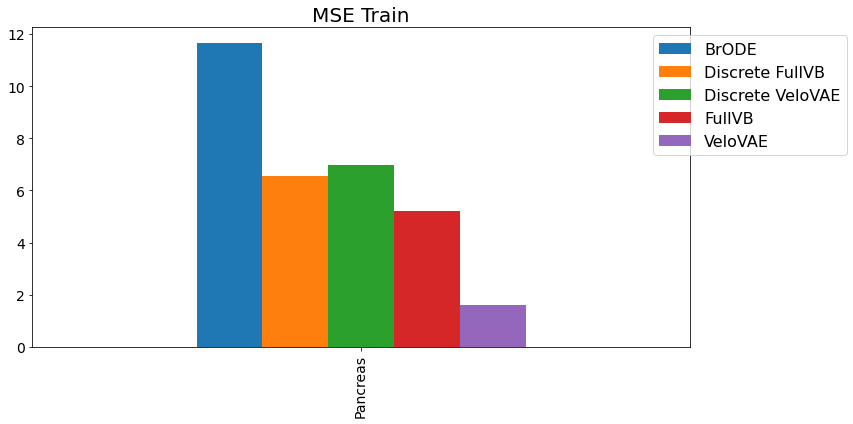

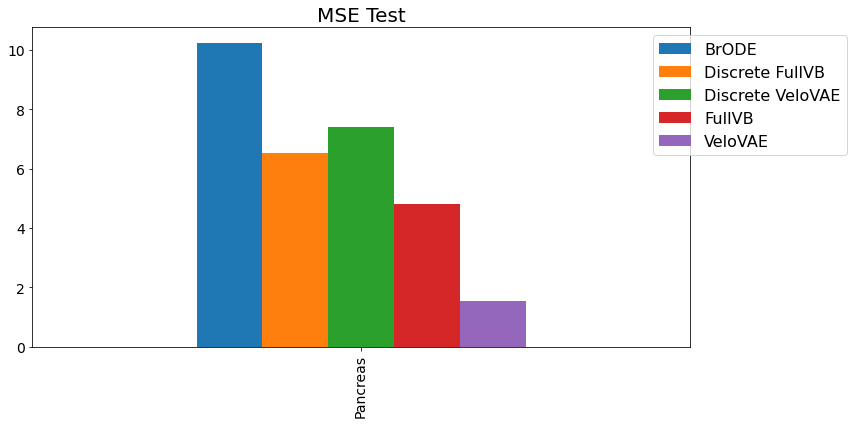

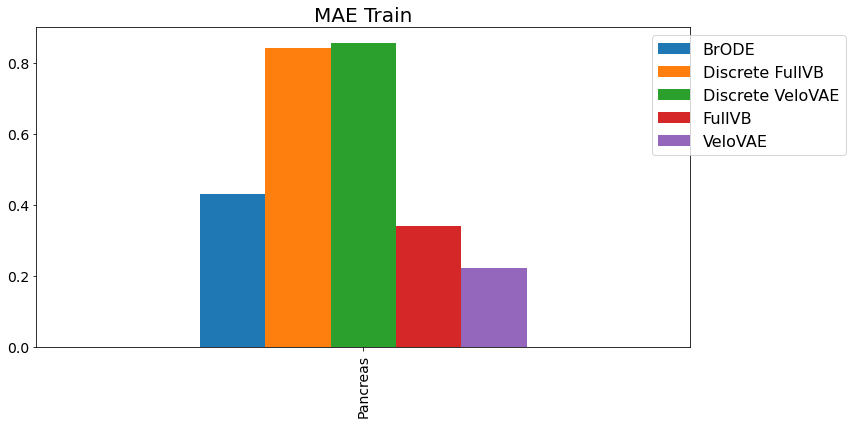

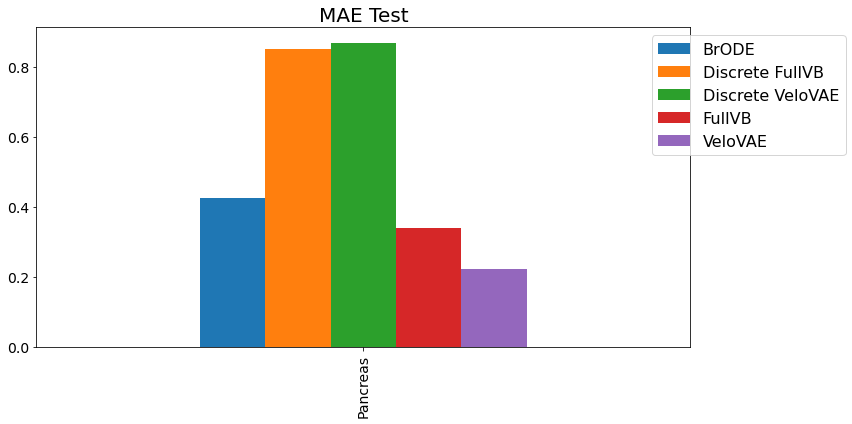

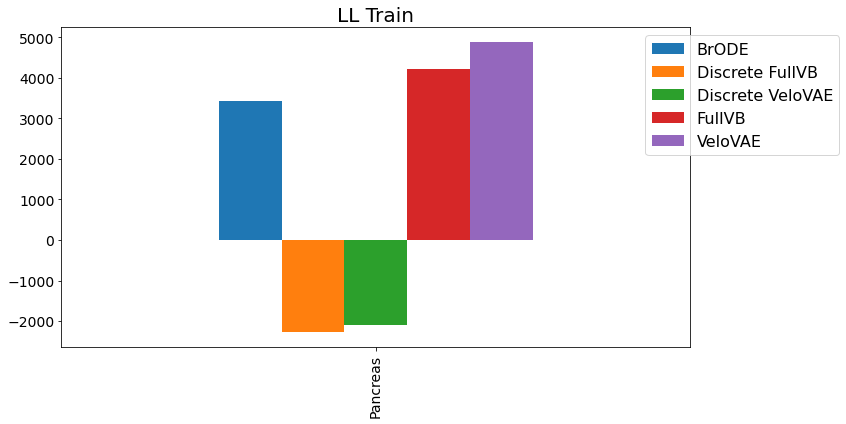

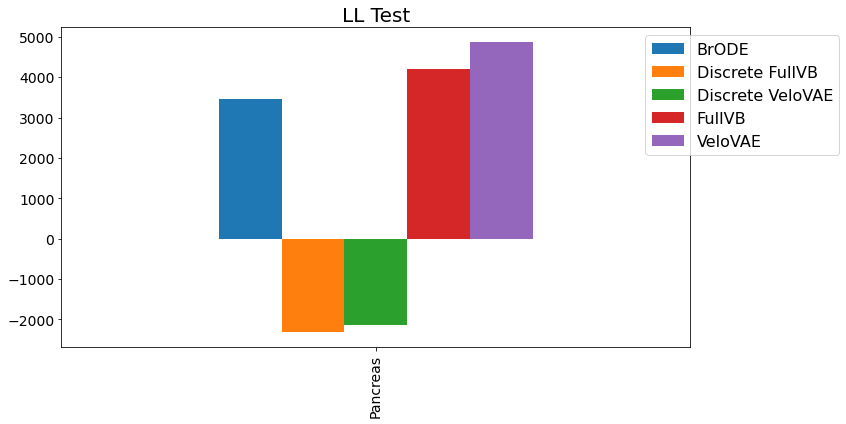

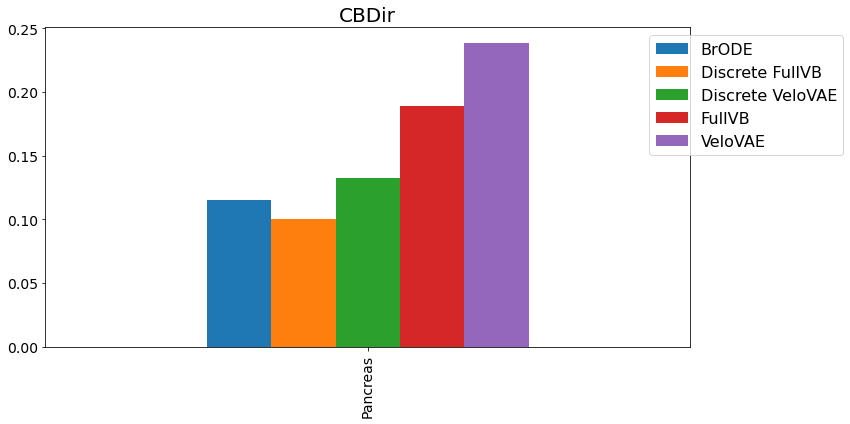

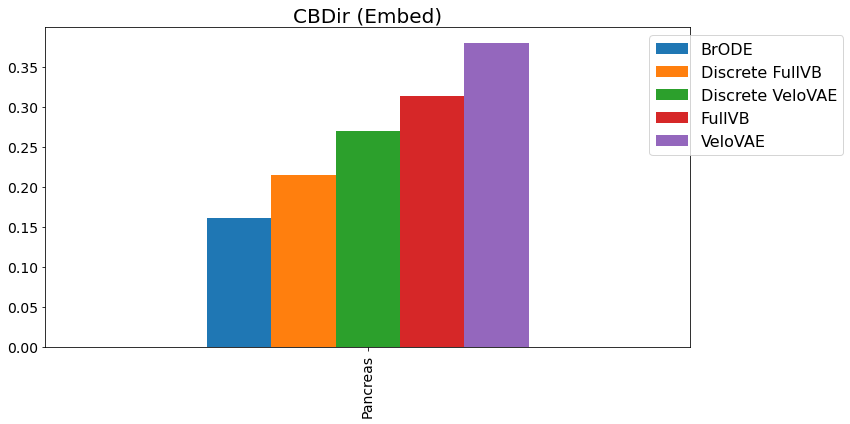

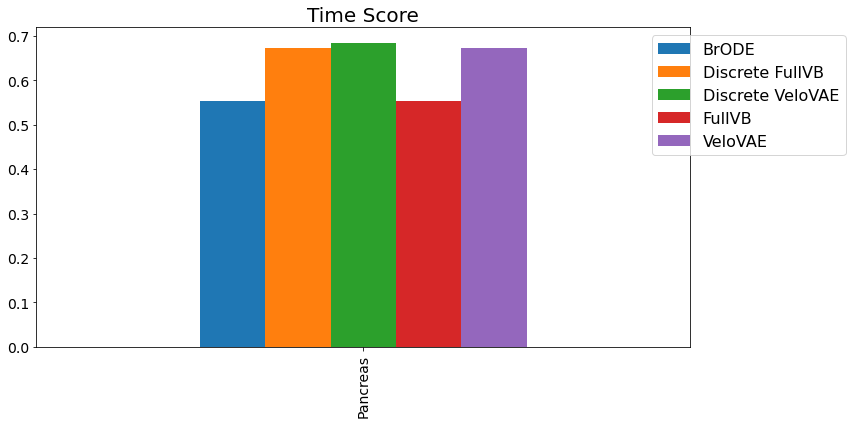

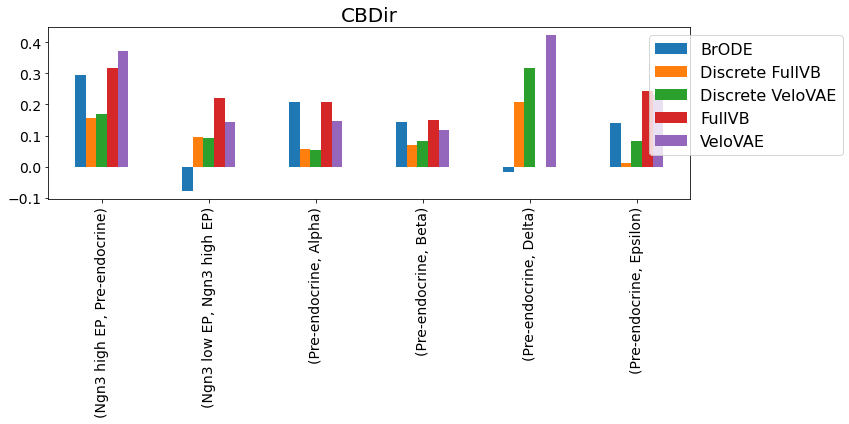

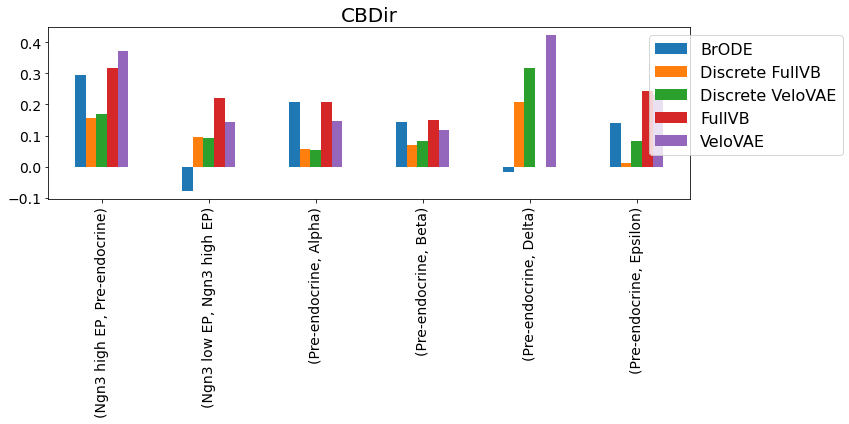

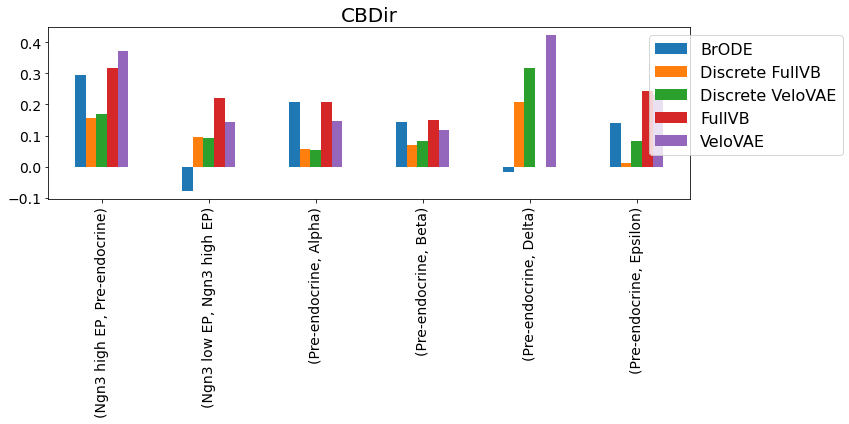

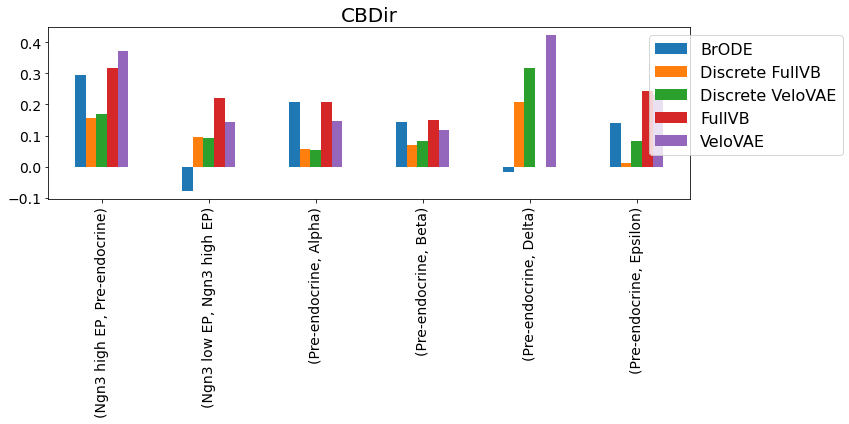

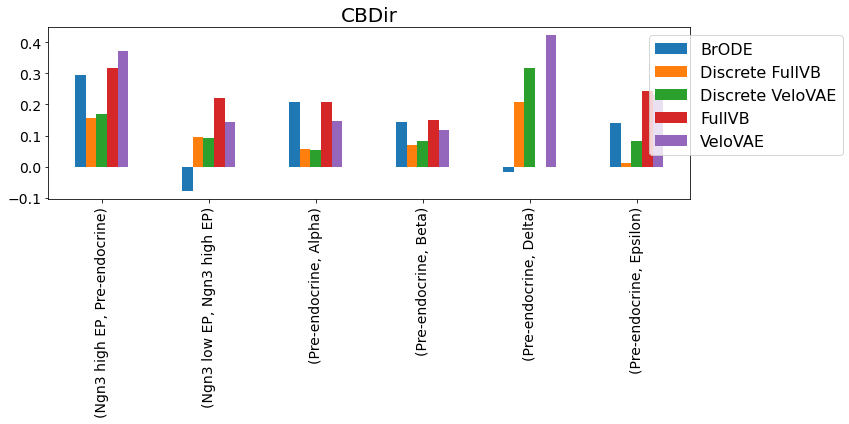

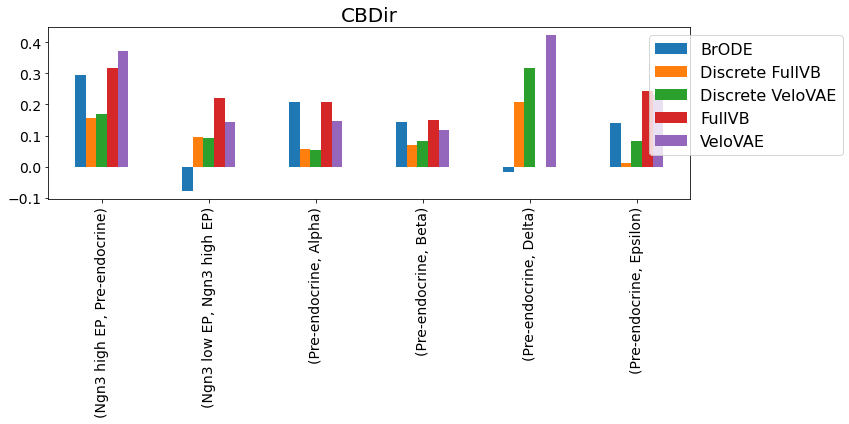

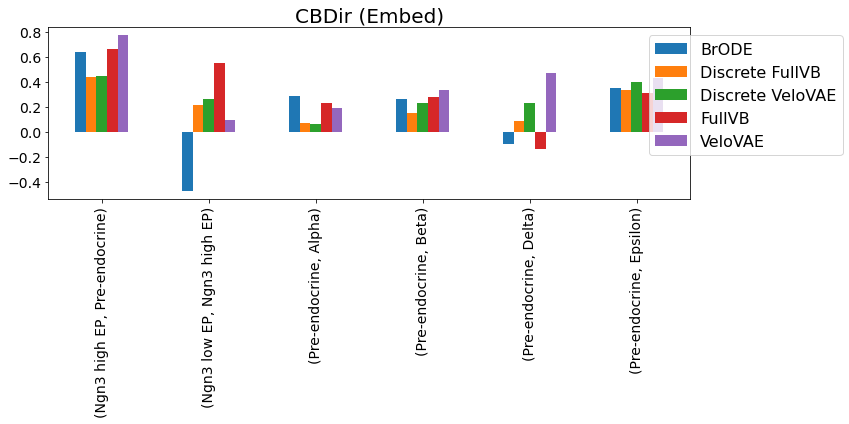

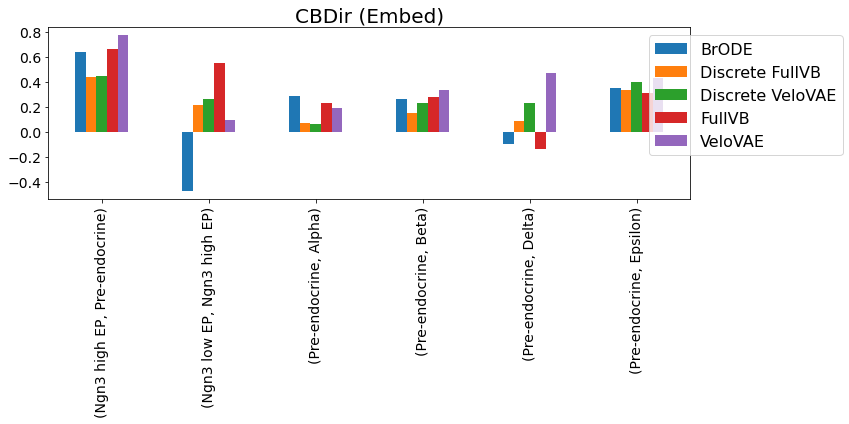

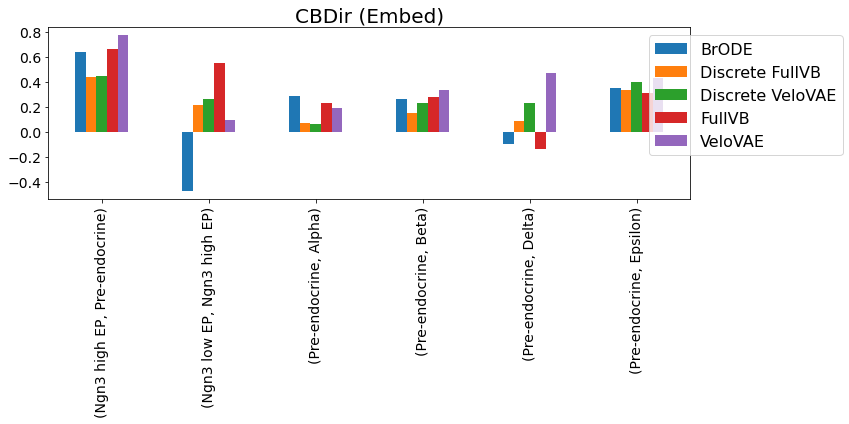

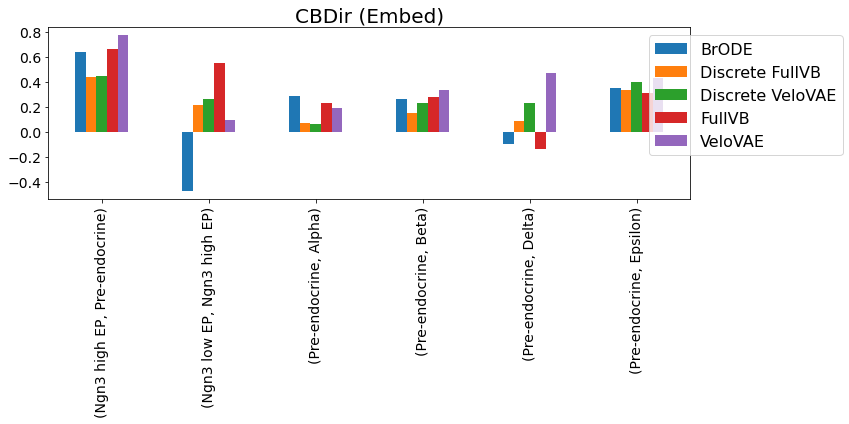

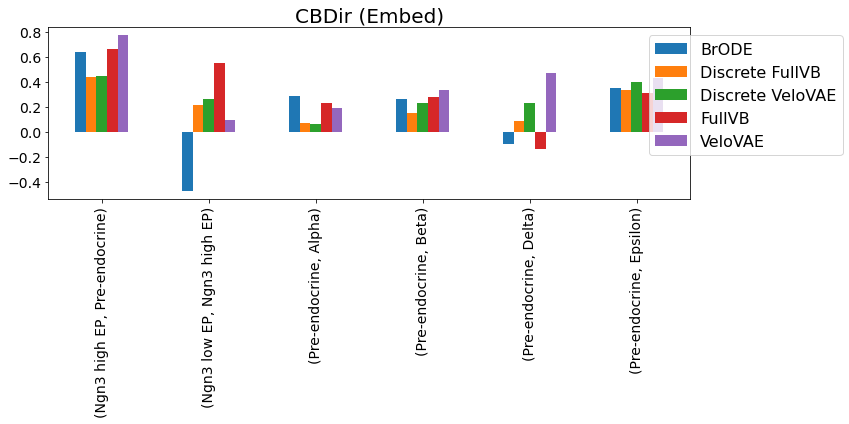

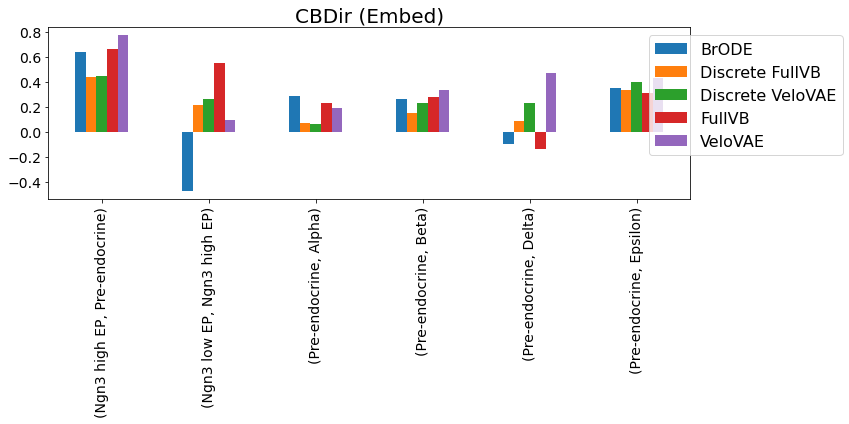

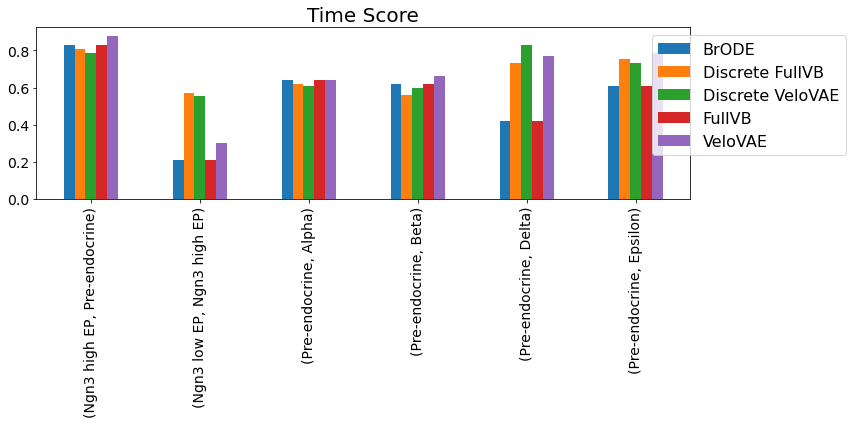

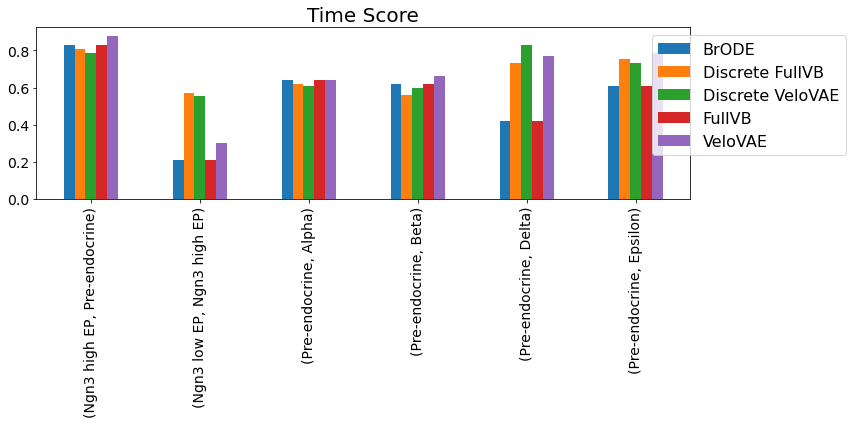

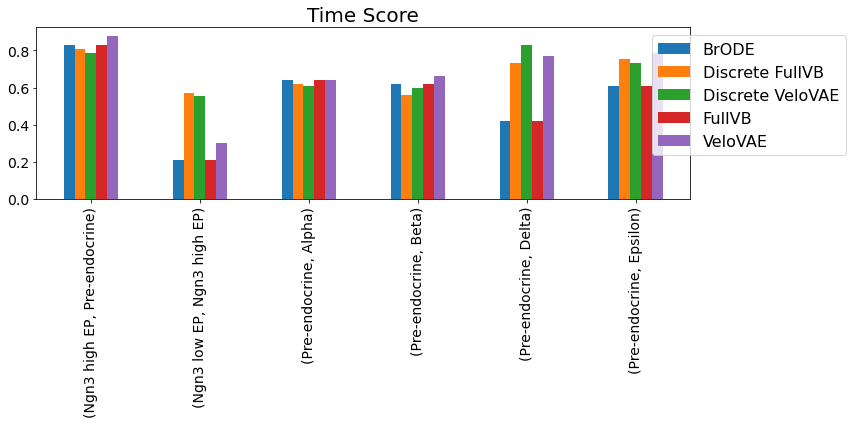

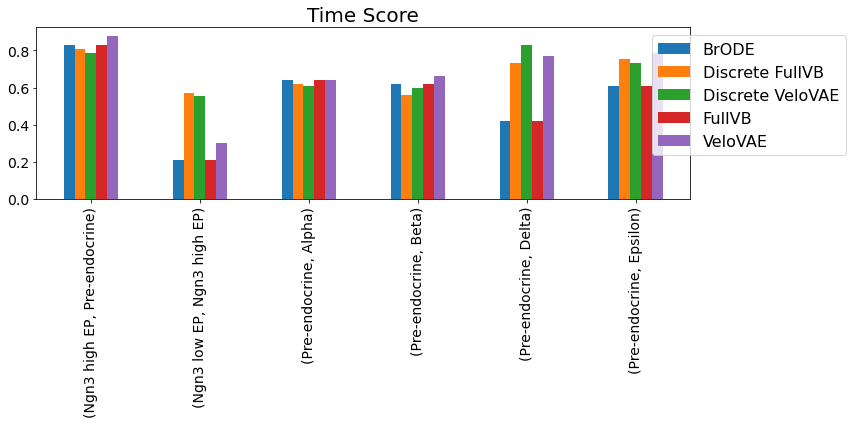

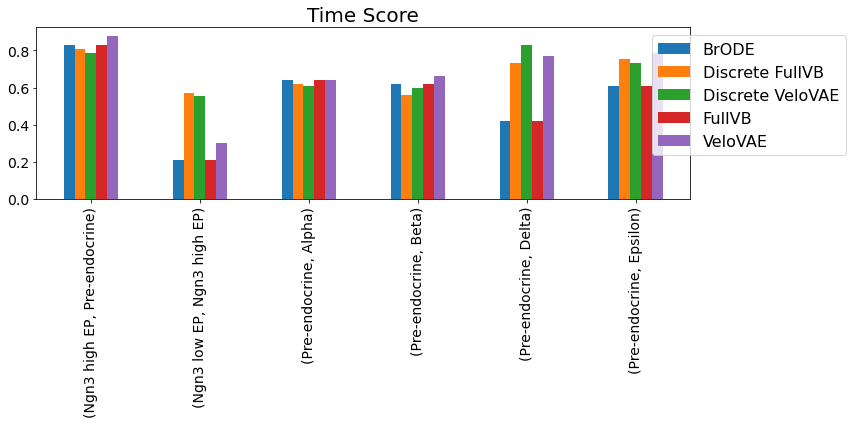

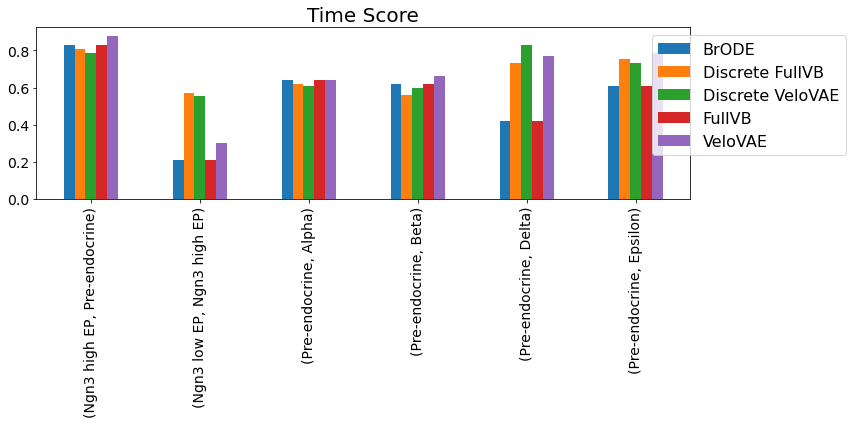

In [21]:
perf_logger.plot()

## Cell Time and State Uncertainty
We can call plot_state_var and plot_time_var directly from the velovae.plotting module.

In [22]:
key = "vae"
basis = "umap"

In [23]:
std_z = adata.obsm[f"{key}_std_z"]
z = adata.obsm[f"{key}_z"]
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/Pancreas/pancreas_state_var.png")

In [24]:
t = adata.obs["fullvb_time"].to_numpy()
std_t = adata.obs["fullvb_std_t"].to_numpy()
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_time_var(std_t, X_embed, t, save=f"figures/Pancreas/pancreas_time_var.png")

## Other Results
The following plots are not part of the package and we show them here as supplementary results.

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
z = adata.obsm[f'{key}_z']
t = adata.obs[f'{key}_time'].to_numpy()
rho = adata.layers[f'{key}_rho']

cell_labels = adata.obs['clusters'].to_numpy()
cell_types = np.unique(cell_labels)
colors = vv.plotting.get_colors(len(cell_types))

## Result 1: Transcription Rate $\rho$

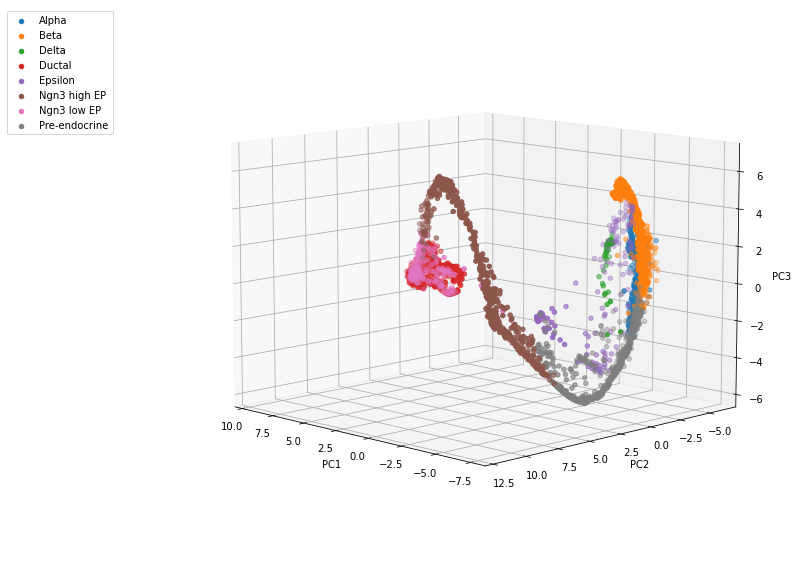

In [38]:
pca = PCA(n_components=3, random_state=42)
rho_pca = pca.fit_transform(rho)

fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(10, 135)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(figure_path+'/rho_pca.png')

## Result 2: Latent Embedding

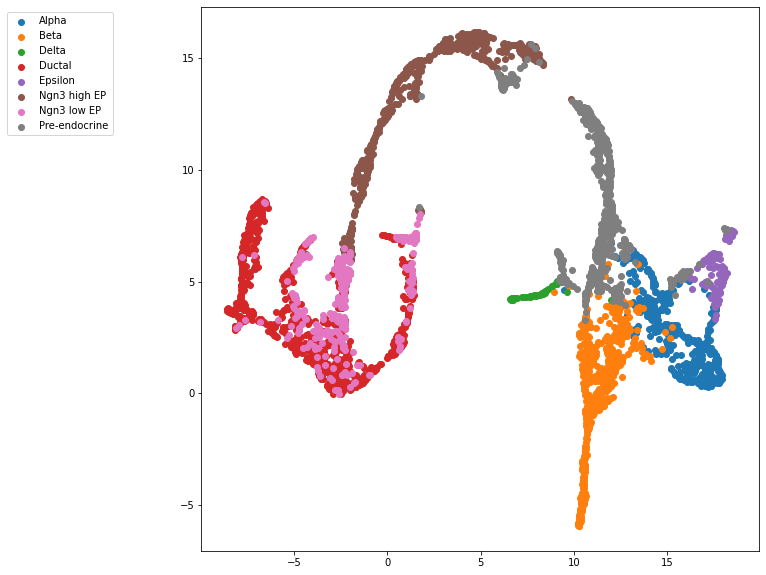

In [42]:
umap_obj = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.25, random_state=0)
z_umap = umap_obj.fit_transform(z)

fig=plt.figure(figsize=(10,10))
for i,x in enumerate((cell_types)):
    plt.scatter(z_umap[cell_labels==x,0], z_umap[cell_labels==x,1], label=x, color=colors[i])
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
fig.savefig(figure_path+'/z_umap.png')